# Load the overlay

In [277]:
from pynq import Overlay

#overlay = Overlay('/home/xilinx/pynq/overlays/User_overlay/Audio_test.bit')
#overlay = Overlay('/home/xilinx/pynq/overlays/User_overlay/AUDIO_test_4.bit')
overlay = Overlay('/home/xilinx/pynq/overlays/User_overlay/FFT_VIDEO_BRAM_TEST.bit')

i2s_RX=overlay.Audio_controller.i2s_audio_stream.i2s_receiver_0
i2s_TX=overlay.Audio_controller.i2s_audio_stream.i2s_transmitter_0
MUX_sel=overlay.Audio_controller.mux_sel

/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:691: UserWarning: Interrupt irq not created: Could not find UIO device for interrupt pin for IRQ number 62
  interrupt, str(e)))
/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:691: UserWarning: Interrupt irq not created: Could not find UIO device for interrupt pin for IRQ number 63
  interrupt, str(e)))


# Read test
Axi protocol for I2S RX and TX
* Reg 0x00 --> Version
* Reg 0x04 --> Configuration (Read only)
* Reg 0x08 --> Enable(0x09)/Disable(0x08)

Go to Logic Core resurces from Xilinx for more info

In [392]:
value=i2s_RX.read(0x00)
print("RX version = " + hex(value))
value=i2s_RX.read(0x04)
print("RX configuration = " + hex(value))

RX version = 0x10000
RX configuration = 0x10201


In [393]:
value=i2s_TX.read(0x00)
print("TX version = " + hex(value))
value=i2s_TX.read(0x04)
print("TX configuration = " + hex(value))

TX version = 0x10000
TX configuration = 0x10200


# Library import

In [280]:
import pynq
from pynq import GPIO
import pynq.lib
import pynq.lib.video
import pynq.lib.audio
import cffi
from pynq import PL
from pynq import GPIO
from pynq.uio import get_uio_index

In [281]:
#define the audio codec
pAudio=overlay.Audio_controller.audio_codec_ctrl_0

In [282]:
pAudio.configure()
pAudio.set_volume(60)
pAudio.select_line_in()

In [283]:
#Configure the audio codec
pAudio.configure(sample_rate=96000)
pAudio.set_volume(60)
pAudio.select_line_in()

In [284]:
#test
#pAudio.bypass(10)

# I2S module functions

In [285]:
def config_TX_i2s(En=True):
    #if sample_rate == 48000:
        #i2s_TX.write(0x20,0x04)
    #elif sample_rate == 96000:
        #i2s_TX.write(0x20,0x02)
    #else:
        #i2s_TX.write(0x20,0x04)
    if En:
        i2s_TX.write(0x08,0x09)
    else:
        i2s_TX.write(0x08,0x08)

In [286]:
def config_RX_i2s(sample_rate=48000, En=True):
    if sample_rate == 48000:
        i2s_RX.write(0x20,0x04)
    elif sample_rate == 96000:
        i2s_RX.write(0x20,0x02)
    else:
        i2s_RX.write(0x20,0x04)
    for i in range(6):
        i2s_RX.write(0x50+i*4,0x00)
    if En:
        i2s_RX.write(0x08,0x09)
    else:
        i2s_RX.write(0x08,0x08)

# Enable continuous bypass from audio codec

In [287]:
def continuous_bypass(En=True, volume=30):
    if volume > 63:
        volume=63
    if volume < 0:
        volume=0
    if En:
        #overlay.mux_sel.write(0,0)
        pAudio.write_audio_REG(0x1D,0x00)
        pAudio.write_audio_REG(0x1F,0x00)
        pAudio.write_audio_REG(0x1C,0x21)
        pAudio.write_audio_REG(0x1E,0x41)
        reg_vol=volume<< 2 |0x3
        pAudio.write_audio_REG(0x23,reg_vol)
        pAudio.write_audio_REG(0x24,reg_vol)
        #overlay.mux_sel.write(0,1)
    else:
        pAudio.write_audio_REG(0x1D,0x00)
        pAudio.write_audio_REG(0x1F,0x00)
        pAudio.write_audio_REG(0x1C,0x00)
        pAudio.write_audio_REG(0x1E,0x00)
        pAudio.write_audio_REG(0x23,0xE5)
        pAudio.write_audio_REG(0x24,0xE5)
        #overlay.mux_sel.write(0,0)

## FFT scaling

In [288]:
import time

config_TX_i2s(False)
config_RX_i2s(96000,False)

continuous_bypass(False,0)

sch=0b000001010110
overlay.HDMI_FFT_LR.AXI_FFT_CTRL.write(0,0b10000000000000001 | sch<<1)
#overlay.axi_gpio_0.write(0,0b10000011111111111)
#overlay.axi_gpio_0.write(0,0b10000000000000000)
time.sleep(0.01)
overlay.HDMI_FFT_LR.AXI_FFT_CTRL.write(0,0b00000000000000001 | sch<<1)
#overlay.axi_gpio_0.write(0,0b00000011111111111)
#overlay.axi_gpio_0.write(0,0b00000000000000000)

In [289]:
continuous_bypass(False,0)

In [290]:
continuous_bypass(True,31)

In [291]:
MUX_sel.write(0x0,0x01)

In [292]:
config_RX_i2s(96000,False)
config_TX_i2s(False)

In [293]:
config_RX_i2s(96000,True)
config_TX_i2s(True)

## Windowing
To reduce spectral leakage a windowing is performed, the function can be selected or computed. After that the array is transferred to the dual port RAM in the PL in wchich the multiplication will be performed.

In [307]:
from pynq import MMIO

IP_BASE_ADDRESS = overlay.HDMI_FFT_LR.axi_bram_ctrl_0.mmio.base_addr
ADDRESS_RANGE   = 0x2000

mmio = MMIO(IP_BASE_ADDRESS, ADDRESS_RANGE)

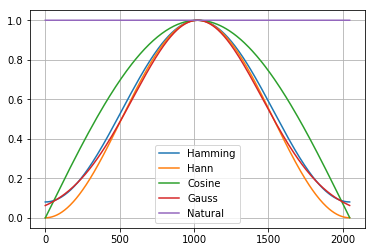

In [389]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,2047,2048)
data_window    = np.cos(np.pi*(x-1024)/2047)**2
Hann_window    = np.asarray((2**16-1)*data_window, dtype=np.int32)

data_window    = 0.54+0.46*np.cos((2*np.pi*(x-1024))/(2047))
Hamming_window = np.asarray((2**16-1)*data_window, dtype=np.int32)

data_window    = np.cos((np.pi*(x-1024))/(2047))
Cosine_window  = np.asarray((2**16-1)*data_window, dtype=np.int32)

data_window    = np.exp(-(((x-1024)/2047)**2)/(0.09))
Gauss_window  = np.asarray((2**16-1)*data_window, dtype=np.int32)

No_window      = np.asarray((2**16-1)*np.ones(2048), dtype=np.int32)

plt.plot(x,Hamming_window/65535, label='Hamming')
plt.plot(x,Hann_window/65535,    label='Hann'   )
plt.plot(x,Cosine_window/65535,  label='Cosine' )
plt.plot(x,Gauss_window/65535,   label='Gauss'  )
plt.plot(x,No_window/65535,      label='Natural')

plt.grid(True)
plt.legend()
plt.show()

In [395]:
for i in range(2048):
    mmio.write(i<<2,int(Hamming_window[i]))